In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

/Users/dhiss/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/train"
validation_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/validasi"

In [3]:
# Augmentasi Data untuk Pelatihan
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,        # Rotasi hingga 30 derajat
    width_shift_range=0.2,    # Perpindahan horizontal
    height_shift_range=0.2,   # Perpindahan vertikal
    shear_range=0.2,          # Shearing
    zoom_range=0.2,           # Zooming
    horizontal_flip=True,     # Flipping horizontal
    fill_mode="nearest"       # Penanganan piksel kosong
)

# Validasi tetap hanya di rescale
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# Load data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 2259 images belonging to 6 classes.


In [5]:
# Load data validasi
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 898 images belonging to 6 classes.


In [6]:
# Model Transfer Learning dengan ResNet50
base_model = ResNet50(include_top=False, input_shape=(180, 180, 3), weights='imagenet')

base_model.trainable = False

# Model Sequential
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.0002)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation="softmax")
])

2024-12-27 16:48:05.287031: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-27 16:48:05.287054: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-27 16:48:05.287057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-27 16:48:05.287251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 16:48:05.287263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 6, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,494,548 (120.14 MB)

 Trainable params: 2,633,222 (10.04 MB)

 Non-trainable params: 23,594,880 (90.01 MB)

 Optimizer params: 5,266,446 (20.09 MB)

In [7]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# filepath = '/Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras'

# checkpoint = ModelCheckpoint(filepath,
#         monitor = 'val_loss',
#         save_best_only=True,
#         verbose = 1)
# callback_list = [checkpoint]

# Callbacks
filepath = '/Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [9]:
# Training
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=callback_list,
)

/Users/dhiss/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


2024-12-27 16:48:08.814171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.6002 - loss: 1.6573
Epoch 1: val_loss improved from inf to 1.10288, saving model to /Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 792ms/step - accuracy: 0.6026 - loss: 1.6500 - val_accuracy: 0.8274 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7984 - loss: 0.9814
Epoch 2: val_loss improved from 1.10288 to 0.78252, saving model to /Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 676ms/step - accuracy: 0.7987 - loss: 0.9799 - val_accuracy: 0.8753 - val_loss: 0.7825 - learning_rate: 0.0010
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8286 - loss: 0.8719
Epoch 3: val_loss improved from 0.78252 to 0.70691, saving model to /Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 678ms/step - accuracy: 0.8288 - loss: 0.8713 - val_accuracy: 0.8953 - val_loss: 0.

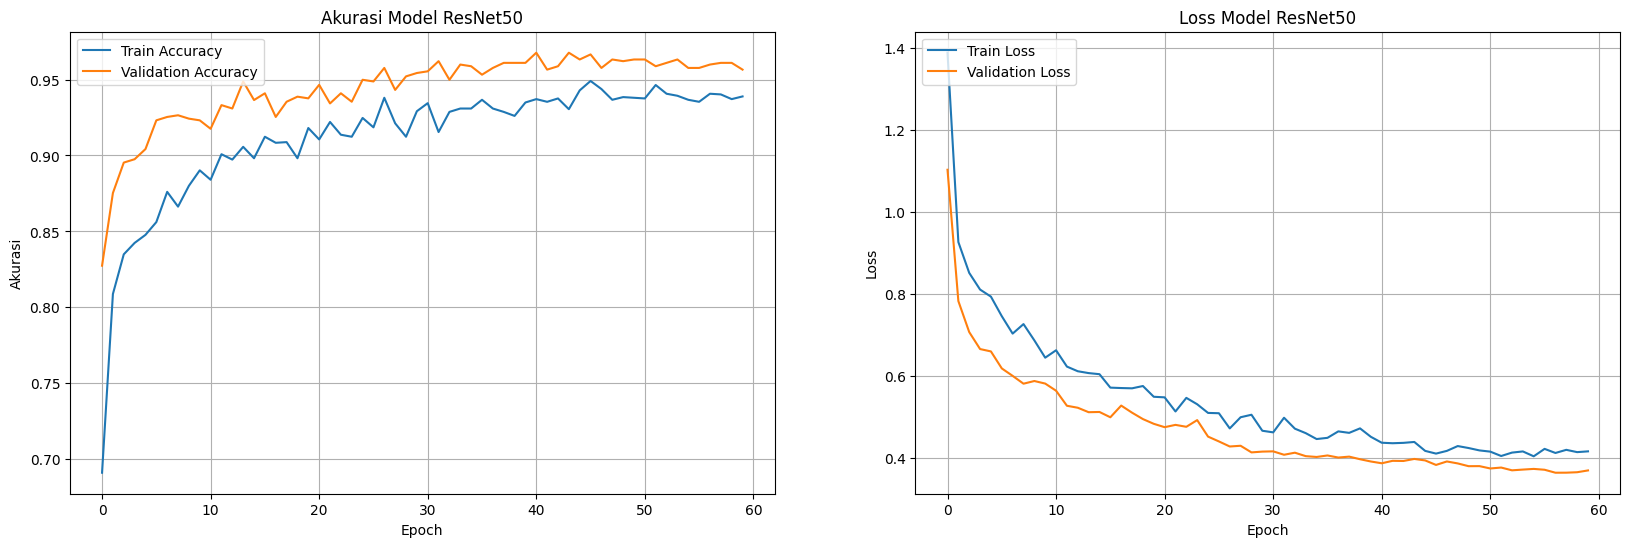

In [10]:
# Plotting accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Akurasi Model ResNet50')
ax1.set_ylabel('Akurasi')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Model ResNet50')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

Found 487 images belonging to 6 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - accuracy: 0.9558 - loss: 0.3820
Loss: 0.3804374933242798
Accuracy: 0.9568789005279541
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 891ms/step

Metrics using sklearn:
Accuracy: 0.9568788501026694
Precision: 0.9595510250017765
Recall: 0.9568788501026694
F1 Score: 0.9574030753853513

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.96      0.98        77
       glass       0.96      0.94      0.95        95
       metal       0.86      0.99      0.92        77
       paper       0.99      0.96      0.98       112
     plastic       0.96      0.94      0.95        96
       trash       1.00      0.97      0.98        30

    accuracy                           0.96       487
   macro avg       0.96      0.96      0.96       487
weighted avg       0.96      0.96      0.96       487



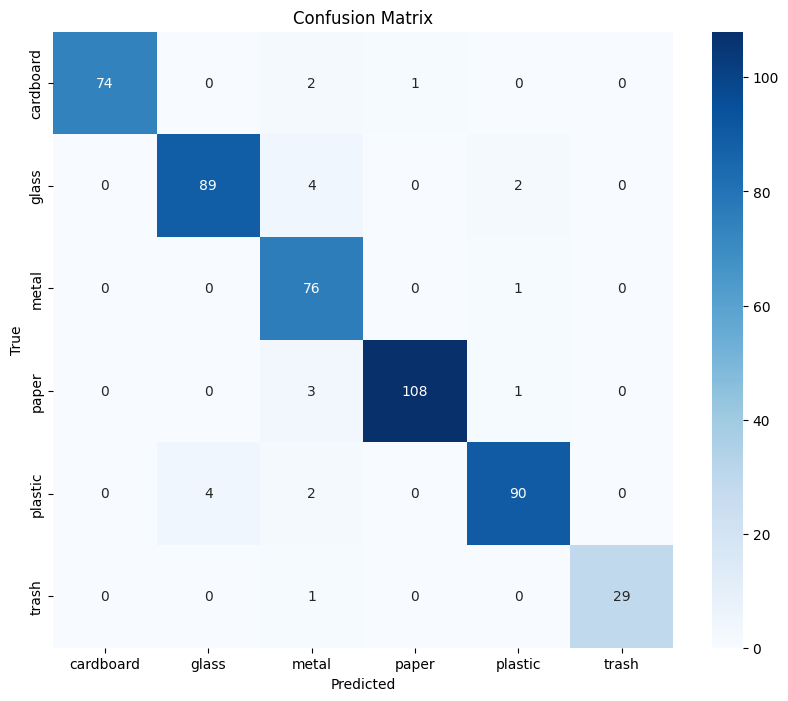

In [11]:
# Path ke model yang disimpan
model_path = '/Users/dhiss/Downloads/TA/FIX/model/ResNetAug.keras'

# Memuat model
model = load_model(model_path)

# Path ke direktori dataset
test_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/uji"

# Membuat objek ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Load data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Pastikan shuffle dinonaktifkan untuk menjaga urutan data
)

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)

# Selesai menghitung waktu
end_time = time.perf_counter()

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Menghitung prediksi untuk data uji
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya dari test_generator
y_true = test_generator.classes

# Mendapatkan label class dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung metrik menggunakan sklearn
accuracy_sklearn = accuracy_score(y_true, y_pred)
precision_sklearn = precision_score(y_true, y_pred, average='weighted')
recall_sklearn = recall_score(y_true, y_pred, average='weighted')
f1_sklearn = f1_score(y_true, y_pred, average='weighted')

print("\nMetrics using sklearn:")
print(f"Accuracy: {accuracy_sklearn}")
print(f"Precision: {precision_sklearn}")
print(f"Recall: {recall_sklearn}")
print(f"F1 Score: {f1_sklearn}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
